# Run PEDSIM to simulate ROH
This is not the original version to simulate ROH for the paper, but a Leipzig 2025 one (for follow up analysis)

In [1]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt

### Do the Arial 
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the default
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("bionc21"):
    print("Leipzig head node detected.")
    path = "/mnt/archgen/users/hringbauer/git/ped-sim/"  # The Path on Midway Cluster
elif socket_name.startswith("hpc"):
    print("Leipzig HPC node.")
    path = "/mnt/archgen/users/hringbauer/git/ped-sim/"  # The Path on Midway Cluster
elif socket_name.startswith("Harald-Laptop"):
    print("Harald's new laptop detected!")
    path = "/home/hringbauer/git/ped-sim/" 
elif socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/ped-sim/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning(f"Not compatible machine: {socket_name}. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./package/")  # Go to the hapsburg package directory

from hapsburg.PackagesSupport.pp_individual_roh_csvs import post_process_roh_df, combine_ROH_df, calc_average_roh
from hapsburg.figures.plot_bars import plot_panel_row, prepare_dfs_plot, create_cousins_roh

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

hpc030
Leipzig HPC node.
/mnt/archgen/users/hringbauer/git/ped-sim
CPU Count: 128


## Check that ped-sim is installed
Otherwise follow install instruction 

In [2]:
!./ped-sim


ERROR: def, map, and output prefix names required
ERROR: must specify crossover model, --pois or --intf, or use --fixedCOfile

Pedigree simulator!  v1.4.2    (Released 24 Aug 2024)

Usage:
./ped-sim [ARGUMENTS]

REQUIRED ARGUMENTS:
  -d <filename>		def file describing pedigree structures to simulate
  -m <filename>		genetic map file containing either a sex averaged map
			  or both male and female maps (format in README.md)
  -o <prefix>		output prefix (creates <prefix>.vcf, <prefix>.bp, etc.)
			  if input VCF is gzipped, output is too
 AND EITHER:
  --intf <filename>	shape, escape values for interference model RECOMMENDED
 OR:
  --pois		Poisson crossover model (no interference)
 OR:
  --fixed_co <filename>	fixed crossovers to use for simulating


OPTIONS:
  -i <filename>		input VCF containing phased samples to use as founders
			  can be gzipped (with .gz extension) or not
			  required for genetic data output
  -X <string>		assign the label of the X chromosome (default: X)
  --sexe

## Define Helper Funcions

In [6]:
def run_pedsim(par_file="par/ibd/gp1.def",
               output="output/ibd/gp1",
               gmap="map/refined_mf.simmap",
               o_file="output/ibd/gp1",
               i_file="interfere/nu_p_campbell.tsv"):
    """Wrapper to run pedsim"""
    !./ped-sim -d $par_file -m $gmap -o $output --intf $i_file

# 1) Run Simualtions

### 1a) Simulate offspring of full sibs

In [7]:
%%time
### First cousin offspring
run_pedsim(par_file="par/roh_sim/roh_fs.def", output="output/roh/roh_fs")

Pedigree simulator!  v1.4.2    (Released 24 Aug 2024)

  Def file:		par/roh_sim/roh_fs.def
  Map file:		map/refined_mf.simmap
  Input VCF:		[none: no genetic data]
  Output prefix:	output/roh/roh_fs

  Random seed:		2728925802

  Interference file:	interfere/nu_p_campbell.tsv

Simulating haplotype transmissions... done.
done.ing IBD segments... 

To simulate genetic data, must use an input VCF with 2000 founders.
CPU times: user 24.7 ms, sys: 14.3 ms, total: 39 ms
Wall time: 1.53 s


### 1b) Simulate offspring of parent-childern

In [10]:
%%time
### First cousin offspring
run_pedsim(par_file="par/roh_sim/roh_po.def", output="output/roh/roh_po")

Pedigree simulator!  v1.4.2    (Released 24 Aug 2024)

  Def file:		par/roh_sim/roh_po.def
  Map file:		map/refined_mf.simmap
  Input VCF:		[none: no genetic data]
  Output prefix:	output/roh/roh_po

  Random seed:		4237910016

  Interference file:	interfere/nu_p_campbell.tsv

Simulating haplotype transmissions... done.
done.ing IBD segments... 

To simulate genetic data, must use an input VCF with 2000 founders.
CPU times: user 11.9 ms, sys: 15 ms, total: 26.9 ms
Wall time: 1.31 s


# 2) Process ROH Segments

In [60]:
def load_segment_file(path_segments="../ped-sim/output/output.seg",
                      roh_only=False, cm_fac=0.01):
    """Load and return segment File of IBD & ROH blocks.
    Return Pandas dataframe. 
    roh_only: Only load ROH blocks
    cm_fac: Factor with which to multiply genetic length columns"""
    df = pd.read_csv(path_segments, sep="\t", header=None)
    df.columns = ["iid1", "iid2", "ch", "Start", "End", 
                  "ibd_stat", "StartM", "EndM", "lengthM"]
    df["length"] = (df["End"] - df["Start"])
    
    for col in ["StartM", "EndM", "lengthM"]:
        df[col] = df[col] * cm_fac
        
    if roh_only:
        df = extract_roh_df(df)
    return df

def extract_roh_df(df, col="ibd_stat", stat="HBD"):
    """Extract and return Dataframe of ROH segments 
    in hapsburg format"""
    df = df[df[col]==stat]
    df = df.drop(columns="iid2")
    df = df.rename(columns={"iid1": "iid"})
    return df

def to_hapsburg_df(path_segments = "../ped-sim/output/test.seg", clst="1st_cousin",
                   savepath = "", n=500,
                   min_cm=[4, 8, 12, 20, 30, 40, 50], snp_cm=100,
                   gap=0.5, min_len1=2, min_len2=4,
                   output=False, sort=True):
    """Load pd_sim output and post_process into Hapsburg
    Summary output. Return this dataframe.
    If savepath is given, save to there (tab-seperated)"""
    df1 = load_segment_file(path_segments, roh_only=True)  # Load the full segment file, transfomred

    ### Split up into lists of Dataframes
    grouped = df1.groupby(['iid'])
    df_rohs = [x[1] for x in list(grouped)] 
    iids = [x[0] for x in list(grouped)]
    
    ### Add Individuals with 0 ROH
    iids1 = ["iid" + str(i) for i in range(len(iids),n)]
    df_rohs1 = [pd.DataFrame(columns = df1.columns) for _ in range(len(iids),n)]
    
    iids = iids + iids1
    df_rohs = df_rohs + df_rohs1
    
    ### Create the combine Dataframe
    df_roh = combine_ROH_df(df_rohs, iids=iids, pops=clst, 
             min_cm=min_cm, snp_cm=snp_cm,
             gap=gap, min_len1=min_len1, min_len2=min_len2,
             output=output, sort=sort)
    
    ### Some Minor Updates to stay compatible with hapsburg 
    # Full Format
    df_roh["age"]=0
    df_roh["clst"] = df_roh["pop"]
    
    if len(savepath)>0:
        df_roh.to_csv(savepath, sep="\t", index=False)
        print(f"Saved to: {savepath}")    
    return df_roh, df1

In [61]:
%%time
df1, df11 = to_hapsburg_df(path_segments = "./output/roh/roh_fs.seg", 
                     clst="Full Sibling", savepath="./output/roh/roh_fs.tsv", n=1000)

Saved to: ./output/roh/roh_fs.tsv
CPU times: user 31 s, sys: 65.3 ms, total: 31.1 s
Wall time: 31 s


In [62]:
%%time
df2, df22 = to_hapsburg_df(path_segments = "./output/roh/roh_po.seg", 
                     clst="Parent Offspring", savepath="./output/roh/roh_po.tsv", n=1000)

Saved to: ./output/roh/roh_po.tsv
CPU times: user 25.6 s, sys: 45.7 ms, total: 25.6 s
Wall time: 25.6 s


# 3) Visualize and explore simulated ROH

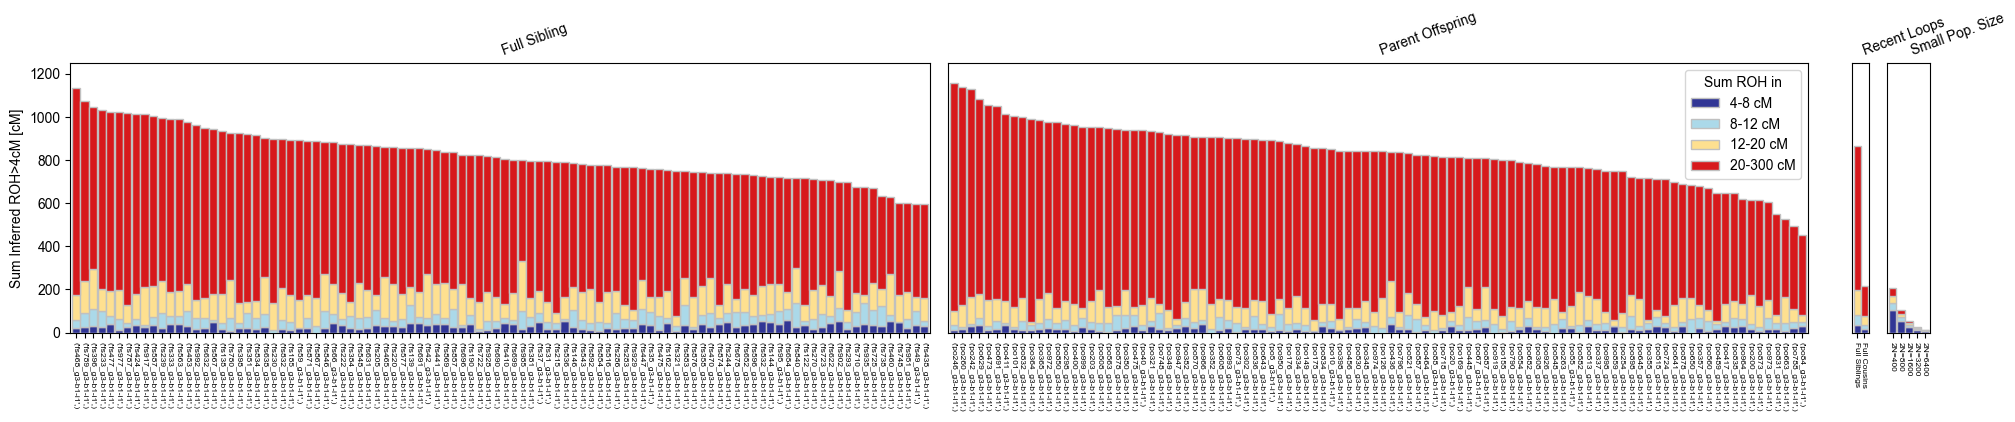

In [25]:
df1 = pd.read_csv("./output/roh/roh_fs.tsv", sep="\t")
df2 = pd.read_csv("./output/roh/roh_po.tsv", sep="\t")

dfs_plot = [df.sample(n=100).sort_index() for df in [df1,df2]]

#df1 = pd.read_csv("./Empirical/Eigenstrat/Example/combined_roh05.csv", sep='\t')
#plot_dfs, cols = prepare_dfs_plot(df1, cms=[4, 8, 12, 20])

# ./figures_test/freilich20_bars.pdf
plot_panel_row(dfs_plot, wspace=0.05, r_title=20, leg_pos=-1, degrees=[0,1], ticks_c=['Full Siblings', 'Full Cousins'],
               fs_x=6, ylim=[0,1250], figsize=(24,3.5), savepath="") # ./figs/n100_hs_c1_c2_offspring.pdf

### Scatter Plot

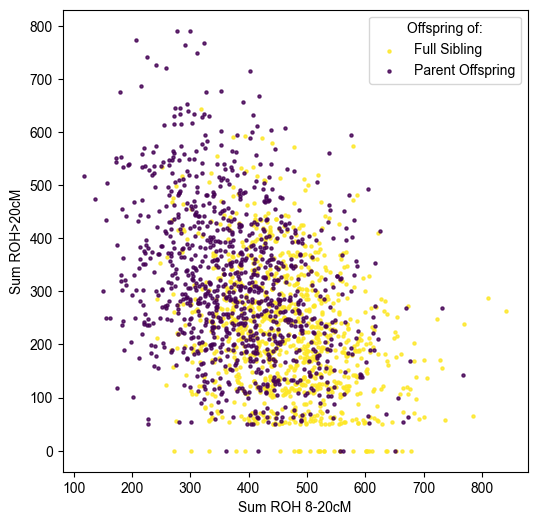

In [89]:
x_col, y_col = "sum_roh>8", "sum_roh>50"
x_col1= "sum_roh>40"

plt.figure(figsize=(6,6))
ax=plt.gca()
ax.scatter(df1[x_col]-df1[x_col1], df1[y_col], label="Full Sibling", c="#fde725", alpha=0.8, s=5)
ax.scatter(df2[x_col]-df2[x_col1], df2[y_col], label="Parent Offspring", c="#440154", alpha=0.8, s=5)

ax.legend(title="Offspring of:")
ax.set_xlabel("Sum ROH 8-20cM")
ax.set_ylabel("Sum ROH>20cM")
plt.show()

In [26]:
df1

,max_roh,iid,pop,sum_roh>4,n_roh>4,sum_roh>8,n_roh>8,sum_roh>12,n_roh>12,sum_roh>20,n_roh>20,age,clst
0,81.814540,"('fs528_g3-b1-i1',)",Full Sibling,1266.303098,39,1238.708403,35,1194.283109,31,1138.797592,28,0,Full Sibling
1,87.024333,"('fs707_g3-b1-i1',)",Full Sibling,1225.674682,37,1206.653104,33,1184.692012,31,1098.074375,26,0,Full Sibling
2,132.729219,"('fs727_g3-b1-i1',)",Full Sibling,1224.871139,38,1199.928775,34,1157.876860,30,999.247215,20,0,Full Sibling
3,139.045826,"('fs940_g3-b1-i1',)",Full Sibling,1205.079142,37,1193.395246,35,1173.077643,33,997.535080,22,0,Full Sibling
4,93.525119,"('fs153_g3-b1-i1',)",Full Sibling,1176.193071,42,1143.102454,37,1105.430980,33,927.029295,22,0,Full Sibling
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,59.050467,"('fs337_g3-b1-i1',)",Full Sibling,467.226080,24,451.139220,21,422.601896,18,280.902693,9,0,Full Sibling
996,59.631241,"('fs262_g3-b1-i1',)",Full Sibling,466.796192,27,434.638891,22,400.747124,18,200.249859,6,0,Full Sibling
997,55.140569,"('fs517_g3-b1-i1',)",Full Sibling,447.451166,22,433.153827,19,376.915974,13,330.400604,10,0,Full Sibling
998,48.308996,"('fs610_g3-b1-i1',)",Full Sibling,442.067419,23,427.523709,21,376.960512,16,209.522169,6,0,Full Sibling
